# LSTM Neural Network for Time Series Prediction

see http://www.jakob-aungiers.com/articles/a/LSTM-Neural-Network-for-Time-Series-Prediction

## Recap: Architecture of an LSTM in general

Where from left to right $ f_t $ is the forget gate (which values to forget), $ i_t $ is the input gate (which values to update), $ \tilde{C}_t $ is the update gate (adds filtered input to cell state), $ o_t $ is the output gate.

![LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
![LSTM_legend](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png)

The key to LSTMs is the cell state, the horizontal line running through the top of the diagram. It is kind of like a conveyor belt (Förderband) that runs down the entire chain. 
The LSTM can add or remove information to the cell state, regulated by structures called *gates*.

Gates are composed out of a sigmoid neural net layer and a pointwise multiplication operation. Sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through. 

A LSTM has three of these gates, to protect and control the cell state.

- **Forget gate layer:** Sigmoid layer that decides which element of the cell state $C_{t-1}$ is kept to what extend (number between 0 and 1).

E.g. in a language model: the gender of the (old) present subject in cell state should be forgotten once a new subject is seen.
 
![LSTM_forget](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)


The next step is to decide what information we're going to store in the cell state. This has two parts: 

- **Input gate layer:** Decides which values we'll update (matrice with values between 0 and 1 through sigmoid).

Next a `tanh` layer creates a vector of new candidate values, $\tilde{C}_t$ (between -1 and 1 through `tanh`), that could be added to the state based on $i_t$. 

E.g. Add the gender of the new subject to the cell state.

![detail_LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

In order to update the old cell state, $C_{t-1}$, into the new cell state $C_t$, we multiply the old state by $f_t$, forgetting the things we decided to forget earlier and then add $i_t*\tilde{C}_t$, the new candidate values (scaled by how much we decided to update each state value).

E.g. Actually drop information about old subject's gender and add the new information.

![LSTM_3](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

- **Output gate layer:** Decide what to output. First run a `sigmoid` layer to decide what parts of the cell state we're going to output. Then, we put the (updated!) cell state through `tanh` to push the values to be between -1 and 1 and multiply it by the output of the `sigmoid` gate.

E.g. It might output whether the subject is singular or plural, so that we know what form a verb should be conjugated into if that’s what follows next.

![LSTM_4](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

## Implementation of univariate time series prediction

In [27]:
import numpy as np
from matplotlib import pyplot as plt

In [35]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [37]:
# transform and load time series
def load_data(filename, seq_length, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')
    sequence_length = seq_length + 1
    result = []
    # divide raw data into sequences -> goes until index: len(data) - seq_len
    for index in range(len(data) - sequence_length):
        result.append(data[index:index+sequence_length])
    
    # necessary as 
    if normalise_window:
        result = normalise_windows(result)
        
    result = np.array(result)
    # train/test split -> 0.9/0.1
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    # np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    
    # reshape vectors to fit LSTM input in keras
    # keras expects: (N, W, F) where N is the number of training sequences, W is the sequence length and F is the number of features of each sequence
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # f = 1
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]
    

In [24]:
import os
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

In [29]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# build LSTM model with network structure of [1, 50, 100, 1]
# 1 input layer (sequence of size 50) 
# 1 LSTM layer with 50 neurons
# 1 LSTM layer with 100 neurons
# 1 fully-connected layer of 1 neuron with a linear activation function
def build_model(layers):
    model = Sequential()
    
    model.add(LSTM(input_dim=layers[0], output_dim=layers[1], return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss='mse', optimizer='rmsprop')
    print('> Compilation Time: ', time.time() - start)
    return model

In [33]:
def predict_point_by_point(model, data):
    # Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,)) # to 1d vector
    return predicted

> Compilation Time:  0.026865005493164062
Train on 4233 samples, validate on 223 samples
Epoch 1/1
4233/4233 [==============================] - 8s - loss: 0.1882 - val_loss: 0.0344


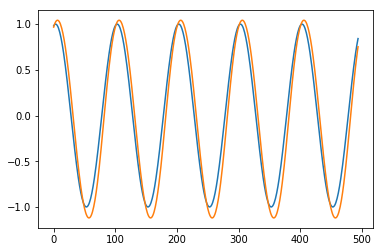

In [31]:
# train model and predict point
epochs = 1 # due to triviality of the sinwave
seq_len = 50

X_train, y_train, X_test, y_test = load_data('sinwave.csv', 50, False)

model = build_model([1, 50, 100, 1])

model.fit(X_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

predicted = predict_point_by_point(model, X_test)

plt.plot(y_test)
plt.plot(predicted)
plt.show()

In [52]:
# train model and predict stock prices
epochs = 1
seq_len = 50
global_start_time = time.time()
    
X_train, y_train, X_test, y_test = load_data('sp500.csv', seq_len, True)

model = build_model([1, 50, 100, 1])

model.fit(X_train, y_train, batch_size=512, nb_epoch=epochs, validation_split=0.05)

> Compilation Time:  0.026327133178710938
Train on 3523 samples, validate on 186 samples
Epoch 1/1
3523/3523 [==============================] - 7s - loss: 0.0021 - val_loss: 0.0011


In [53]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data) / prediction_len)):
        curr_frame = data[i * prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis, :, :])[0, 0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(
                curr_frame, [window_size - 1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [54]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    # Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

Training duration (s) :  27.288140058517456


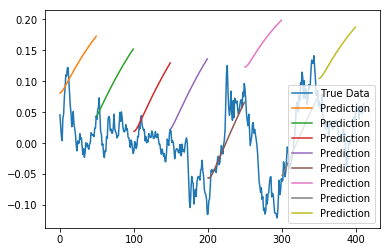

In [55]:
predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)
#predicted = lstm.predict_point_by_point(model, X_test)        

print('Training duration (s) : ', time.time() - global_start_time)
plot_results_multiple(predictions, y_test, 50)
